# RdAnalysis object-oriented API


This juypter notebook is intended to the RdTools analysis workflow as implimented with the rdtools.RdAnalysis object-oriented API. For a consistent experience, we recommend installing the packages and versions documented in `docs/notebook_requirements.txt`. This can be achieved in your environment by running `pip install -r docs/notebook_requirements.txt` from the base directory. (RdTools must also be separately installed.)

The calculations consist of two phases
 1. Import and preliminary calculations: In this step data is important and augmented to enable analysis with RdTools. **No RdTools functions are used in this step. It will vary depending on the particulars of your dataset. Be sure to understand the inputs RdTools requires and make appropriate adjustments.**  
 2. Analysis with RdTools: This notebook illustrates the use of the RdAnalysis API to perform sensor and clearsky degradation rate calculations along with stocasithc rate and recovery (SRR) soiling calculations.

This notebook works with public data from the the Desert Knowledge Australia Solar Centre. Please download the site data from Site 12, and unzip the csv file in the folder:
./rdtools/docs/

Note this example was run with data downloaded on Sept. 28, 2018. An older version of the data gave different sensor-based results. If you have an older version of the data and are getting different results, please try redownloading the data.

http://dkasolarcentre.com.au/historical-data/download

In [1]:
from datetime import timedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pvlib
import rdtools
%matplotlib inline

In [2]:
#Update the style of plots
import matplotlib
matplotlib.rcParams.update({'font.size': 12,
                           'figure.figsize': [4.5, 3],
                           'lines.markeredgewidth': 0,
                           'lines.markersize': 2
                           })

# 1: Import and preliminary calculations


This section prepares the data necesary for an `rdtools` calculation.

A common challenge is handling datasets with and without daylight savings time. Make sure to specify a `pytz` timezone that does or does not include daylight savings time as appropriate for your dataset.

**The steps of this section may change depending on your data source or the system being considered. Note that nothing in this first section utlizes the `rdtools` library.** Transposition of irradiance and modeling of cell temperature are generally outside the scope of `rdtools`. A variety of tools for these calculations are avaialble in [`pvlib`](https://github.com/pvlib/pvlib-python).

In [3]:
file_name = '84-Site_12-BP-Solar.csv'

df = pd.read_csv(file_name)
df = df.rename(columns = {
    u'12 BP Solar - Active Power (kW)':'power',
    u'12 BP Solar - Wind Speed (m/s)': 'wind',
    u'12 BP Solar - Weather Temperature Celsius (\xb0C)': 'Tamb',
    u'12 BP Solar - Global Horizontal Radiation (W/m\xb2)': 'ghi',
    u'12 BP Solar - Diffuse Horizontal Radiation (W/m\xb2)': 'dhi'
})

# Specify the Metadata
meta = {"latitude": -23.762028,
        "longitude": 133.874886,
        "timezone": 'Australia/North',
        "gamma_pdc": -0.005,
        "azimuth": 0,
        "tilt": 20,
        "power_dc_rated": 5100.0,
        "temp_model_params": 'open_rack_glass_polymer'}

df.index = pd.to_datetime(df.Timestamp)
# TZ is required for irradiance transposition
df.index = df.index.tz_localize(meta['timezone'], ambiguous = 'infer') 

# Explicitly trim the dates so that runs of this example notebook 
# are comparable when the sourec dataset has been downloaded at different times
df = df['2008-11-11':'2017-05-15']

# Chage power from kilowatts to watts
df['power'] = df.power * 1000.0

# There is some missing data, but we can infer the frequency from the first several data points
freq = pd.infer_freq(df.index[:10])

# Calculate POA irradiance from DHI, GHI inputs
loc = pvlib.location.Location(meta['latitude'], meta['longitude'], tz = meta['timezone'])
sun = loc.get_solarposition(df.index)

# calculate the POA irradiance
sky = pvlib.irradiance.isotropic(meta['tilt'], df.dhi)
df['dni'] = (df.ghi - df.dhi)/np.cos(np.deg2rad(sun.zenith))
beam = pvlib.irradiance.beam_component(meta['tilt'], meta['azimuth'], sun.zenith, sun.azimuth, df.dni)
df['poa'] = beam + sky

# Calculate POA irradiance from DHI, GHI inputs
loc = pvlib.location.Location(meta['latitude'], meta['longitude'], tz = meta['timezone'])
sun = loc.get_solarposition(df.index)
df['dni'] = (df.ghi - df.dhi)/np.cos(np.deg2rad(sun.apparent_zenith))
poa = pvlib.irradiance.get_total_irradiance(meta['tilt'], meta['azimuth'], sun['apparent_zenith'],
                                                             sun['azimuth'], df['dni'], df['ghi'],
                                                             df['dhi'], albedo=0.25, model='isotropic')
df['poa'] = poa['poa_global']

# Use of the object oriented system analysis API

The first step is to create a `RdAnalysis` instance containing data to be analyzed and information about the system. Here we illustrate a basic applicaiton, but the API is highly customizable and we encourage you to read the docstrings and check the source for full details.

In [4]:
rd = rdtools.RdAnalysis(df['power'], df['poa'], 
                             ambient_temperature=df['Tamb'],
                             temperature_coefficient=meta['gamma_pdc'],
                             interp_freq=freq,
                             max_timedelta=pd.to_timedelta('15 minutes'),
                             windspeed=df['wind'],
                             temperature_model=meta['temp_model_params'])

A second step is required to set up the clearsky model, which needs to be localized and have tilt/orientation information.

In [5]:
rd.set_clearsky(pvlib_location=loc, pv_tilt=meta['tilt'], pv_azimuth=meta['azimuth'], albedo=0.25)

Once the `RdAnalysis` object is ready, the `sensor_analysis()` and `clearsky_analysis()` methods can be used to deploy the full chain of analysis steps. Results are stored in nested dict, `RdAnalysis.results`.

Filters utilized in the analysis can be adjusted by changing the dict `RdAnalysis.filter_params`.

In [6]:
rd.sensor_analysis(analyses=['yoy_degradation', 'srr_soiling'])
rd.clearsky_analysis()

The results of the calculations are stored in a nested dict, `RdAnalysis.results`

In [7]:
yoy_results = rd.results['sensor']['yoy_degradation']
srr_results = rd.results['sensor']['srr_soiling']

In [8]:
# Print the sensor-based analysis p50 degradation rate and confidence interval
print(yoy_results['p50_rd'])
print(yoy_results['rd_confidence_interval'])

-0.44132287274254445
[-0.54702397 -0.35208522]


In [9]:
# Print the clear-sky-based analysis p50 degradation rate and confidence interval
cs_yoy_results = rd.results['clearsky']['yoy_degradation']
print(cs_yoy_results['p50_rd'])
print(cs_yoy_results['rd_confidence_interval'])

0.00833101747703731
[-0.12778687  0.15079403]


In [10]:
# Print the p50 inoslation-weighted soiling ration and confidence interval
print(srr_results['p50_sratio'])
print(srr_results['sratio_confidence_interval'])

0.9761360319007901
[0.97242596 0.97941629]


## Plotting
The `RdAnalysis` class has built in methods for making useful plots

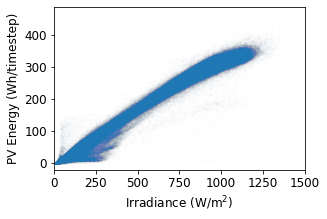

In [11]:
# check that PV energy is roughly proportional to irradiance
# Loops and other features in this plot can indicate things like
# time zone problems for irradiance transposition errors.
fig = rd.plot_pv_vs_irradiance('sensor');

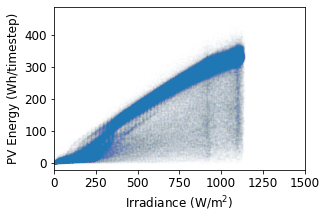

In [12]:
# Repeat the check for clear-sky irradiance
# For this plot, we expect more points below the main point
# cloud due to cloudy conditions.
fig = rd.plot_pv_vs_irradiance('clearsky');

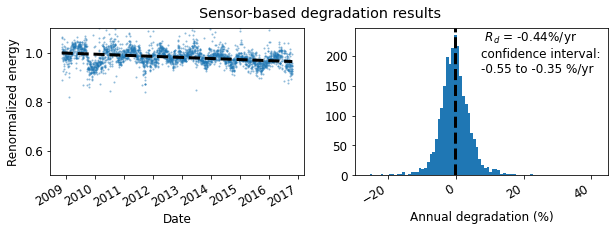

In [13]:
# Plot the sensor based degradation results
fig = rd.plot_degradation_summary('sensor', summary_title='Sensor-based degradation results',
                                   scatter_ymin=0.5, scatter_ymax=1.1,
                                   hist_xmin=-30, hist_xmax=45);

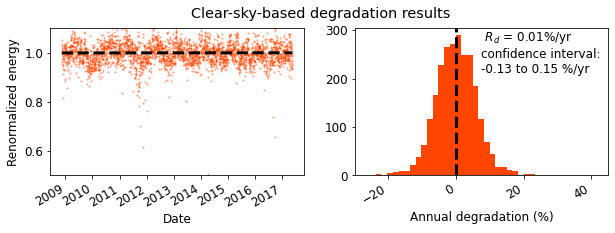

In [14]:
# Plot the clear-sky-based results
fig = rd.plot_degradation_summary('clearsky', summary_title='Clear-sky-based degradation results',
                                   scatter_ymin=0.5, scatter_ymax=1.1,
                                   hist_xmin=-30, hist_xmax=45, plot_color='orangered');

The RdAnalysis class also has built-in methods for plots associated with soiling analysis

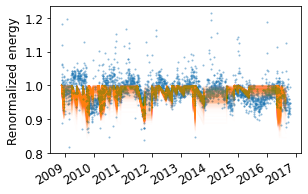

In [15]:
fig = rd.plot_soiling_monte_carlo('sensor', profile_alpha=0.01, profiles=500);

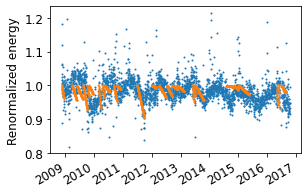

In [16]:
fig = rd.plot_soiling_interval('sensor');

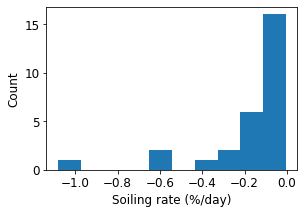

In [17]:
fig = rd.plot_soiling_rate_histogram('sensor');

We can also view a table of the valid soiling intervals and associated metrics

In [18]:
interval_summary = rd.results['sensor']['srr_soiling']['calc_info']['soiling_interval_summary']
interval_summary[interval_summary['valid']].head()

,start,end,soiling_rate,soiling_rate_low,soiling_rate_high,inferred_start_loss,inferred_end_loss,length,valid
0,2008-11-13 00:00:00+09:30,2008-12-11 00:00:00+09:30,-0.001393,-0.003567,0.000000,1.021841,0.982846,28,True
3,2009-03-25 00:00:00+09:30,2009-05-24 00:00:00+09:30,-0.000736,-0.001029,-0.000441,1.044817,1.000640,60,True
4,2009-05-25 00:00:00+09:30,2009-08-11 00:00:00+09:30,-0.000530,-0.000703,-0.000335,1.041782,1.000477,78,True
5,2009-08-12 00:00:00+09:30,2009-10-05 00:00:00+09:30,-0.001331,-0.001911,-0.000759,1.049971,0.978099,54,True
6,2009-10-06 00:00:00+09:30,2009-10-27 00:00:00+09:30,-0.001649,-0.003780,0.000000,0.954045,0.919423,21,True


## Modifying the filters
Filters can be adjusted from their default paramters by modifying the attribute `RdAnalysis.filter_params`, which is a dict where the keys are names of functions in `rdtools.filtering`, and the values are a dict of the parameters for the associated filter. In the following example we modify the POA filter to have a low cutoff of 500 W/m^2.

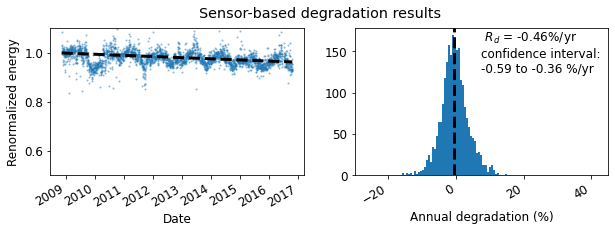

In [19]:
# Instantiate a new instance of RdAnalysis
rd_new_filter = rdtools.RdAnalysis(df['power'], df['poa'], 
                             ambient_temperature=df['Tamb'],
                             temperature_coefficient=meta['gamma_pdc'],
                             interp_freq=freq,
                             max_timedelta=pd.to_timedelta('15 minutes'),
                             windspeed=df['wind'],
                             temperature_model=meta['temp_model_params'])

# Modify the poa filter parameters
rd_new_filter.filter_params['poa_filter'] = {'poa_global_low':500}

# Run the YOY degradation analysis
rd_new_filter.sensor_analysis()

# Visualize the results
rd_new_filter.plot_degradation_summary('sensor', summary_title='Sensor-based degradation results',
                                   scatter_ymin=0.5, scatter_ymax=1.1,
                                   hist_xmin=-30, hist_xmax=45);

Arbitrary filters can also be used by setting the `ad_hoc_filter` key of the `RdAnalysis.filter_params` atribute to a boolean pandas series that can be used as a filter. In this example we filter for "stuck" values, i.e. values that are repeated consecuatively, which can be associated with faulty measurments.

In [20]:
def filter_stuck_values(pandas_series):
    '''
    Returns a boolean pd.Series which filters out sequentially
    repeated values from pandas_series'
    '''
    diff = pandas_series.diff()
    diff_shift = diff.shift(-1)
    
    stuck_filter = ~((diff == 0) | (diff_shift == 0))
    
    return stuck_filter

In [21]:
# Instantiate a new instance of RdAnalysis
rd_stuck_filter = rdtools.RdAnalysis(df['power'], df['poa'], 
                             ambient_temperature=df['Tamb'],
                             temperature_coefficient=meta['gamma_pdc'],
                             interp_freq=freq,
                             max_timedelta=pd.to_timedelta('15 minutes'),
                             windspeed=df['wind'],
                             temperature_model=meta['temp_model_params'])

In [22]:
rd_stuck_filter.filter_params['ad_hoc_filter'] = (
                                                  filter_stuck_values(df['power']) & 
                                                  filter_stuck_values(df['poa']) &
                                                  filter_stuck_values(df['Tamb']) &
                                                  filter_stuck_values(df['wind'])
                                                 )

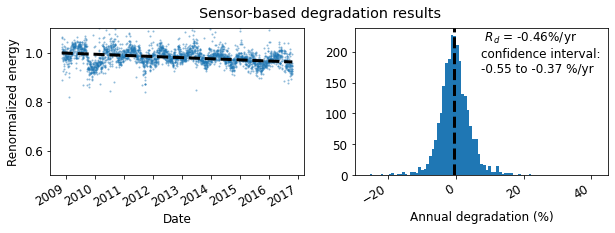

In [23]:
rd_stuck_filter.sensor_analysis()

# Visualize the results
rd_stuck_filter.plot_degradation_summary('sensor', summary_title='Sensor-based degradation results',
                                         scatter_ymin=0.5, scatter_ymax=1.1,
                                         hist_xmin=-30, hist_xmax=45);

## Substituting a different modeled power
Incidentally, you can optionally run the analysis while normalizing with your own calculated expected power.  By default, `RdAnalysis` normalizes by the included `pvwatts_dc_power` calculation.  To override with a different value, pass in `RdAnalysis.power_expected`. You can substitute any modeled power here, like from SAM or PVSyst or PVLib.  

In [24]:
power_expected = rdtools.normalization.pvwatts_dc_power(poa_global=rd.poa,
                                                           power_dc_rated=meta['power_dc_rated'], 
                                                           temperature_cell=rd.cell_temperature,
                                                           gamma_pdc=meta['gamma_pdc'])

rd_with_expected_power = rdtools.RdAnalysis(pv=df['power'], poa=df['poa'],                              
                             power_expected = power_expected,
                             interp_freq=freq,
                             max_timedelta=pd.to_timedelta('15 minutes'),
                             )

In [25]:
rd_with_expected_power.sensor_analysis(analyses=['yoy_degradation'])  # This step will run using power_expected if it's defined.
print(rd.results['sensor']['yoy_degradation']['p50_rd'])  

-0.44132287274254445


Results are the same as above